In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import gc
import pdet
import fpfs
import fitsio
from fpfs import pltutil
import numpy as np
import matplotlib.pylab as plt
import numpy.lib.recfunctions as rfn

ver='try4'
gver='basic2'
dver='cut16'
wrkDir=os.environ['homeWrk']
simDir=os.path.join(wrkDir,'FPFS2/sim/')

In [2]:
#nver='var1em9' # 'var0em0'#
nver='var4em3' # 'var0em0'#
#nver='var0em0' # 'var0em0'#
# read noiseless data
mm1=[]
mm2=[]
for _i in range(1000):
    _a1=fitsio.read(os.path.join(simDir,'srcfs2_%sCenter-%s_%s/psf60/fpfs-%s-%04d-g1-0000.fits' %(gver,nver,ver,dver,_i)))
    _a2=fitsio.read(os.path.join(simDir,'srcfs2_%sCenter-%s_%s/psf60/fpfs-%s-%04d-g1-2222.fits' %(gver,nver,ver,dver,_i)))
    mm1.append(_a1)
    mm2.append(_a2)
    del _a1,_a2#,msk1,msk2
mm1 =   rfn.stack_arrays(mm1,usemask=False)
mm2 =   rfn.stack_arrays(mm2,usemask=False)
detM1=   pdet.peak2det(mm1)
detM2=   pdet.peak2det(mm2)
gc.collect()

9

In [3]:
Const  =   4e-2
noirev =   True
ellM1  =   fpfs.catutil.fpfsM2E(mm1,dets=detM1,const=Const,noirev=noirev)
ellM2  =   fpfs.catutil.fpfsM2E(mm2,dets=detM2,const=Const,noirev=noirev)
gc.collect()

0

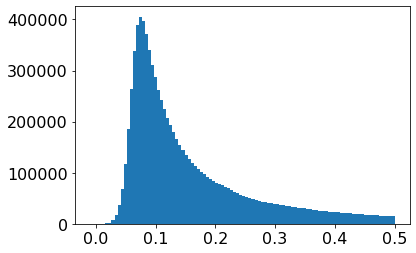

In [4]:
plt.close()
_=plt.hist(detM1['fpfs_v22'],range=(-0.01,0.5),bins=100)

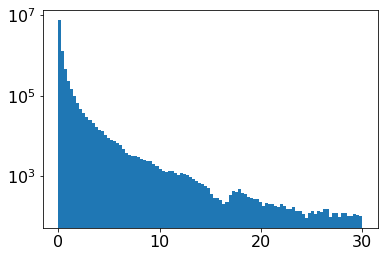

In [5]:
plt.close()
_=plt.hist(mm1['fpfs_M00'],range=(-0.01,30.),bins=100)
plt.yscale('log')

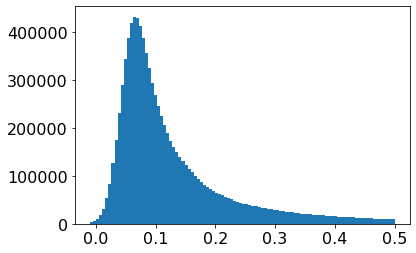

In [6]:
plt.close()
_=plt.hist(-mm1['fpfs_M20'],range=(-0.01,0.5),bins=100)

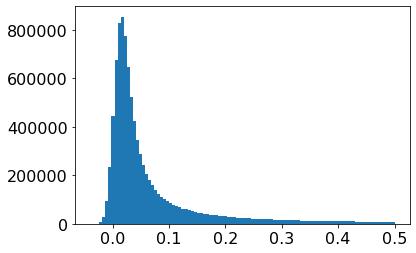

In [7]:
plt.close()
_=plt.hist(mm1['fpfs_M00']+mm1['fpfs_M20'],range=(-0.04,0.5),bins=100)

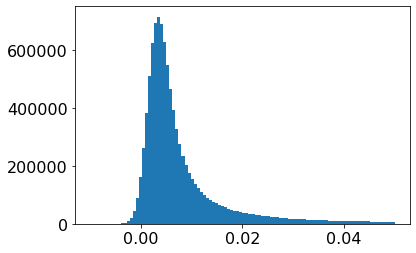

In [18]:
plt.close()
_=plt.hist(detM1['fpfs_v21'],range=(-0.01,0.05),bins=100)

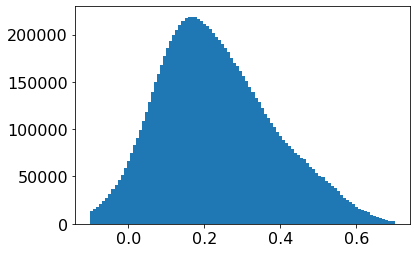

In [8]:
plt.close()
_=plt.hist(ellM1['fpfs_RE'],range=(-0.1,0.7),bins=100)

In [41]:
gc.collect()
selnm='fpfs_M00';cornm='fpfs_RS0';nornm='fpfs_HR00';nornm2='fpfs_HE100'
scol1=mm1[selnm];scol2=mm2[selnm]
ccol1=ellM1[cornm];ccol2=ellM2[cornm]
cncol1=ellM1[nornm];cncol2=ellM2[nornm]
nncol1=ellM1[nornm2];nncol2=ellM2[nornm2]


dcc=0.06 # delta cut
cutB=0.
cutsig=0.08
use_sig=False

fpSel=fpfs.base.Selection(mu=cutB,sigma=cutsig,use_sig=use_sig)

x=[]
y1=[];y2=[];yerr=[]
z1=[];z2=[];zerr=[]
for i in range(0,8):
    # update cut array
    cut=cutB+dcc*i
    print(cut)
    fpSel.mu=cut
    # weight array
    ws1 = fpSel.get_wsel(scol1)
    ws2 = fpSel.get_wsel(scol2)
    cor1 = fpSel.get_wbias(scol1,ws1,ccol1)
    cor2 = fpSel.get_wbias(scol2,ws2,ccol2)
    corD1= fpSel.get_wbias(scol1,ws1,cncol1)
    corD2= fpSel.get_wbias(scol2,ws2,cncol2)
    corN1= fpSel.get_wbias(scol1,ws1,nncol1)
    corN2= fpSel.get_wbias(scol2,ws2,nncol2)
    e1=np.sum(ellM2['fpfs_e1']*ws2)
    e2=np.sum(ellM1['fpfs_e1']*ws1)
    de   = e1-e2
    eA   = (e1+e2)/2.
    eAR  = (e1+e2+corN1+corN2)/2.
    rave = (np.sum(ellM2['fpfs_RE']*ws2)+np.sum(ellM1['fpfs_RE']*ws1))/2.
    raveR= (np.sum(ellM2['fpfs_RE']*ws2)+np.sum(ellM1['fpfs_RE']*ws1)+cor1+cor2+corD1+corD2)/2.
    x.append(cut)
    y1.append(de/rave/0.04-1)
    y2.append(de/raveR/0.04-1)
    yerr.append(0.15*np.sqrt(np.sum((ellM2['fpfs_RE']*ws2)**2.))/raveR/0.04)
    z1.append(eA/rave)
    z2.append(eAR/rave)
    zerr.append(0.15*np.sqrt(np.sum((ellM2['fpfs_RE']*ws2)**2.))/raveR)

0.0
0.06
0.12
0.18
0.24
0.3
0.36
0.42


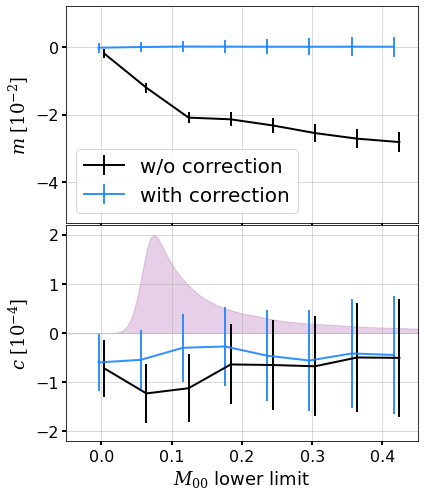

In [49]:
plt.close()
fig,axes=pltutil.make_figure_axes(ny=2,nx=1,square=False)
ax=axes[0]
xlabel='$M_{00}$ lower limit';
ax.errorbar(np.array(x)+0.004,np.array(y1)*1e2,np.array(yerr)*1e2,label='w/o correction',color=pltutil.colors[0])
ax.errorbar(np.array(x)-0.004,np.array(y2)*1e2,np.array(yerr)*1e2,label='with correction',color=pltutil.colors[1])
ax.set_ylabel('$m$ $[10^{-2}]$',fontsize=18)
ax.set_xlim(-0.05,0.45)
ax.set_ylim(-5.2,1.2)
ax.tick_params(width=2,size=4)
hist,bins=np.histogram(mm1['fpfs_M00'],range=(-0.05,0.46),bins=100,density=True)
cbin=(bins[1:]+bins[:-1])/2.
sf=hist.max()/2.
hist=hist/sf
ax.set_xticklabels([])
ax.grid()
ax.legend()

ax=axes[1]
ax.errorbar(np.array(x)+0.004,np.array(z1)*1e4,np.array(zerr)*1e4,label='w/o correction',color=pltutil.colors[0])
ax.errorbar(np.array(x)-0.004,np.array(z2)*1e4,np.array(zerr)*1e4,label='with correction',color=pltutil.colors[1])
ax.set_ylabel('$c$ $[10^{-4}]$',fontsize=18)
ax.set_xlim(-0.05,0.45)
ax.set_ylim(-2.2,2.2)
ax.tick_params(width=2,size=4)
ax.set_xlabel(xlabel,fontsize=18)
ax.fill_between(cbin,hist,color=pltutil.colors[-1],alpha=0.2)
ax.grid()

plt.tight_layout(h_pad=-0.2)

In [50]:
gc.collect()

scol1=mm1['fpfs_M00']+mm1['fpfs_M20']
scol2=mm2['fpfs_M00']+mm2['fpfs_M20']
ccol1=ellM1['fpfs_RS0']+ellM1['fpfs_RS2']
ccol2=ellM2['fpfs_RS0']+ellM2['fpfs_RS2']
cncol1=ellM1['fpfs_HR00']+ellM1['fpfs_HR20']
cncol2=ellM2['fpfs_HR00']+ellM2['fpfs_HR20']
nncol1=ellM1['fpfs_HE100']+ellM1['fpfs_HE120']
nncol2=ellM2['fpfs_HE100']+ellM2['fpfs_HE120']

dcc=0.06 # delta cut
cutB=-0.05 # 
cutsig=0.08
use_sig=False

fpSel=fpfs.base.Selection(mu=cutB,sigma=cutsig,use_sig=use_sig)

x=[]
y1=[];y2=[];yerr=[]
z1=[];z2=[];zerr=[]
for i in range(0,8):
    # update cut array
    cut=cutB+dcc*i
    print(cut)
    fpSel.mu=cut
    # weight array
    ws1 = fpSel.get_wsel(scol1)
    ws2 = fpSel.get_wsel(scol2)
    cor1 = fpSel.get_wbias(scol1,ws1,ccol1)
    cor2 = fpSel.get_wbias(scol2,ws2,ccol2)
    corD1= fpSel.get_wbias(scol1,ws1,cncol1)
    corD2= fpSel.get_wbias(scol2,ws2,cncol2)
    corN1= fpSel.get_wbias(scol1,ws1,nncol1)
    corN2= fpSel.get_wbias(scol2,ws2,nncol2)
    
    e1=np.sum(ellM2['fpfs_e1']*ws2)
    e2=np.sum(ellM1['fpfs_e1']*ws1)
    de   = e1-e2
    eA   = (e1+e2)/2.
    eAR  = (e1+e2+corN1+corN2)/2.
    rave = (np.sum(ellM2['fpfs_RE']*ws2)+np.sum(ellM1['fpfs_RE']*ws1))/2.
    raveR= (np.sum(ellM2['fpfs_RE']*ws2)+np.sum(ellM1['fpfs_RE']*ws1)+cor1+cor2+corD1+corD2)/2.
    x.append(cut)
    y1.append(de/rave/0.04-1)
    y2.append(de/raveR/0.04-1)
    yerr.append(0.15*np.sqrt(np.sum((ellM2['fpfs_RE']*ws2)**2.))/raveR/0.04)
    z1.append(eA/rave)
    z2.append(eAR/rave)
    zerr.append(0.15*np.sqrt(np.sum((ellM2['fpfs_RE']*ws2)**2.))/raveR)

-0.05
0.009999999999999995
0.06999999999999999
0.13
0.19
0.25
0.31
0.37


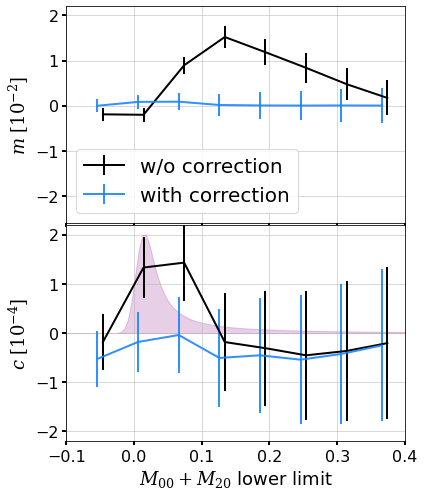

In [53]:
plt.close()
fig,axes=pltutil.make_figure_axes(ny=2,nx=1,square=False)
ax=axes[0]
xlabel='$M_{00}+M_{20}$ lower limit';
ax.errorbar(np.array(x)+0.004,np.array(y1)*1e2,np.array(yerr)*1e2,label='w/o correction',color=pltutil.colors[0])
ax.errorbar(np.array(x)-0.004,np.array(y2)*1e2,np.array(yerr)*1e2,label='with correction',color=pltutil.colors[1])
ax.set_ylabel('$m$ $[10^{-2}]$',fontsize=18)
ax.set_xlim(-0.1,0.4)
ax.set_ylim(-2.6,2.2)
ax.tick_params(width=2,size=4)
hist,bins=np.histogram(mm1['fpfs_M00']+mm1['fpfs_M20'],range=(-0.12,0.42),bins=100,density=True)
cbin=(bins[1:]+bins[:-1])/2.
sf=hist.max()/2.
hist=hist/sf
ax.set_xticklabels([])
ax.grid()
ax.legend()

ax=axes[1]
ax.errorbar(np.array(x)+0.004,np.array(z1)*1e4,np.array(zerr)*1e4,label='w/o correction',color=pltutil.colors[0])
ax.errorbar(np.array(x)-0.004,np.array(z2)*1e4,np.array(zerr)*1e4,label='with correction',color=pltutil.colors[1])
ax.set_ylabel('$c$ $[10^{-4}]$',fontsize=18)
ax.set_xlim(-0.1,0.4)
ax.set_ylim(-2.2,2.2)
ax.tick_params(width=2,size=4)
ax.set_xlabel(xlabel,fontsize=18)
ax.fill_between(cbin,hist,color=pltutil.colors[-1],alpha=0.2)
ax.grid()

plt.tight_layout(h_pad=-0.2)

0.0
0.06
0.12
0.18
0.24
0.3
0.36
0.42
[-0.00048325049875963533, -0.0008742366357099574, -0.0006842507249794627, -0.0002115384389973496, -6.781518696596933e-05, 4.064128639780229e-05, 0.00022036341628650646, 0.00015996349048341685]


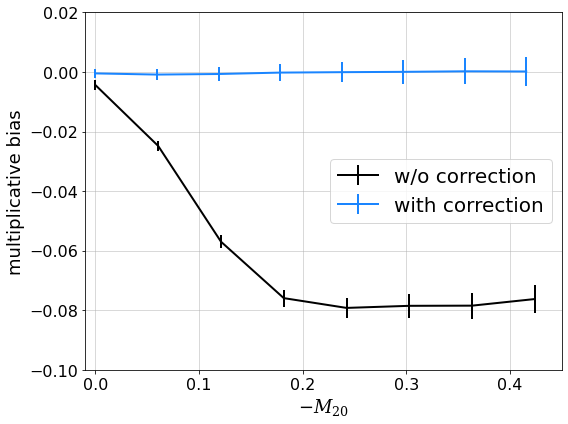

In [42]:
gc.collect()
plt.close()
fig,axes=pltutil.make_figure_axes(1,1)
ax=axes[0]

xlabel='$-M_{20}$';selnm='fpfs_M20';cornm='fpfs_RS2';nornm='fpfs_HR20'
scol1=-mm1[selnm];scol2=-mm2[selnm]
ccol1=-ellM1[cornm];ccol2=-ellM2[cornm]
cncol1=-ellM1[nornm];cncol2=-ellM2[nornm]

ax.set_xlim(-0.01,0.45)

dcc=0.06 # delta cut
cutB=0.00 # 
cutsig=0.08
use_sig=False

fpSel=fpfs.base.Selection(mu=cutB,sigma=cutsig,use_sig=use_sig)

x=[]
y1=[]
y2=[]
yerr=[]
for i in range(0,8):
    # update cut array
    cut=cutB+dcc*i
    print(cut)
    fpSel.mu=cut
    # weight array
    ws1 = fpSel.get_wsel(scol1)
    ws2 = fpSel.get_wsel(scol2)
    cor1 = fpSel.get_wbias(scol1,ws1,ccol1)
    cor2 = fpSel.get_wbias(scol2,ws2,ccol2)
    corD1= fpSel.get_wbias(scol1,ws1,cncol1)
    corD2= fpSel.get_wbias(scol2,ws2,cncol2)
    de   = np.sum(ellM2['fpfs_e1']*ws2)-np.sum(ellM1['fpfs_e1']*ws1)
    rave = (np.sum(ellM2['fpfs_RE']*ws2)+np.sum(ellM1['fpfs_RE']*ws1))/2.
    raveR= (np.sum(ellM2['fpfs_RE']*ws2)+np.sum(ellM1['fpfs_RE']*ws1)+cor1+cor2+corD1+corD2)/2.
    x.append(cut);y1.append(de/rave/0.04-1);y2.append(de/raveR/0.04-1)
    yerr.append(0.15*np.sqrt(np.sum((ellM2['fpfs_RE']*ws2)**2.))/raveR/0.04)

ax.errorbar(np.array(x)*1.01,np.array(y1),np.array(yerr),label='w/o correction',color=pltutil.colors[0])
ax.errorbar(np.array(x)/1.01,np.array(y2),np.array(yerr),label='with correction',color=pltutil.colors[1])
ax.set_xlabel(xlabel)
ax.set_ylabel('multiplicative bias')
ax.set_ylim(-0.10,0.02)
ax.grid()
ax.legend()
plt.tight_layout()
#fig.savefig('../../html/noisy_knownRef_%s.png' %pn)
print(y2)

-0.005
0.005
0.015
0.024999999999999998
0.035
0.045000000000000005
0.055
0.065
[-0.0006228222894740787, -0.0006955454880284151, -0.0007780080772592513, -0.0008606365082948209, -0.0009351368571941521, -0.0009875625556112766, -0.0009831847349434097, -0.0008280611572868413]


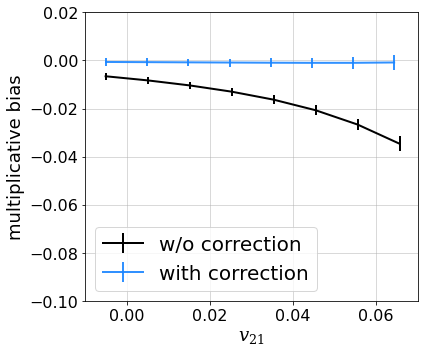

In [20]:
gc.collect()
selnm='fpfs_v21'
cornm='fpfs_RS021'
scol1=detM1[selnm]
scol2=detM2[selnm]
ccol1=ellM1[cornm]
ccol2=ellM2[cornm]

dcc=0.01 # delta cut
cutB=-0.005 # 
cutsig=0.01
x=[];
y1=[];y2=[];yerr=[]
for i in range(0,8):
    # update cut array
    cut=cutB+dcc*i
    print(cut)
    fpSel.mu=cut
    ws1 = fpSel.get_wsel(scol1)
    ws2 = fpSel.get_wsel(scol2)
    cor1 = fpSel.get_wbias(scol1,ws1,ccol1)
    cor2 = fpSel.get_wbias(scol2,ws2,ccol2)
    de   = np.sum(ellM2['fpfs_e1']*ws2)-np.sum(ellM1['fpfs_e1']*ws1)
    rave = (np.sum(ellM2['fpfs_RE']*ws2)+np.sum(ellM1['fpfs_RE']*ws1))/2.
    raveR= (np.sum(ellM2['fpfs_RE']*ws2)+np.sum(ellM1['fpfs_RE']*ws1)+cor1+cor2)/2.
    x.append(cut)
    y1.append(de/rave/0.04-1)
    y2.append(de/raveR/0.04-1)
    yerr.append(0.15*np.sqrt(np.sum((ellM2['fpfs_RE']*ws2)**2.))/raveR/0.04)

plt.close()
fig,axes=pltutil.make_figure_axes(1,1)
ax=axes[0]
ax.errorbar(np.array(x)*1.01,np.array(y1),np.array(yerr),label='w/o correction',color=pltutil.colors[0])
ax.errorbar(np.array(x)/1.01,np.array(y2),np.array(yerr),label='with correction',color=pltutil.colors[1])
xlabel='$v_{21}$'
ax.set_xlabel(xlabel)
ax.set_ylabel('multiplicative bias')
ax.set_xlim(-0.01,0.07)
ax.set_ylim(-0.10,0.02)
ax.grid()
ax.legend()
plt.tight_layout()
#fig.savefig('../../html/noisy_knownRef_%s.png' %pn)
print(y2)

In [ ]:
nver='var4em3' # 'var0em0'# 'var1em9'
hdat=fitsio.read(os.path.join(simDir,'srcfs2_%sCenter-%s_%s/psf60/src-0000-g1-0000.fits' %(gver,nver,ver)))
fdat=fitsio.read(os.path.join(simDir,'srcfs2_%sCenter-%s_%s/psf60/fpfs-%s-0000-g1-0000.fits' %(gver,nver,ver,dver)))
hdat=hdat[hdat['parent']==0]
ipos1=np.int_((hdat['base_NaiveCentroid_y']//64*100)+hdat['base_NaiveCentroid_x']//64)
ipos2=np.int_((fdat['pdet_y']//64*100)+fdat['pdet_x']//64)
assert np.all(ipos2==np.arange(10000))
fdat=fdat[ipos1]


Const  =   0.
edat=fpfs.catutil.fpfsM2E(fdat,dets=None,const=Const,noirev=False)

fig,axes=pltutil.make_figure_axes(ny=2,nx=1)

ax=axes[0]
ax.scatter(fdat['fpfs_M00']/32.**2.,hdat['base_SdssShape_instFlux'],s=0.04,color='black')
ax.set_xlabel('fpfs flux')
ax.set_ylabel('SDSS flux')
ax.set_xlim(0.01,1)
ax.set_ylim(1,50)

ax=axes[1]
ax.scatter(edat['fpfs_s0']-edat['fpfs_s2'],hdat['ext_shapeHSM_HsmSourceMoments_xx']+hdat['ext_shapeHSM_HsmSourceMoments_yy'],s=0.04,color='black')
#ax.scatter(fdat['fpfs_M00']-fdat['fpfs_M20'],hdat['ext_shapeHSM_HsmSourceMoments_xx']+hdat['ext_shapeHSM_HsmSourceMoments_yy'],s=0.04,color='black')
ax.set_xlabel('fpfs trace')
ax.set_ylabel('regauss trace')
plt.tight_layout()